# Time Series Analysis - Final Project
Gur Keinan 213635899    Idan Pipano 213495260

## Importing libraries

In [1]:
%pip install --upgrade tensorflow
%pip install --upgrade yfinance
%pip install --upgrade pykalman
%pip install --upgrade pmdarima

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model

# Suppress all FutureWarnings and UserWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

# Suppress specific UserWarnings from Keras
warnings.filterwarnings('ignore', message="Do not pass an `input_shape`/`input_dim` argument to a layer")
warnings.filterwarnings('ignore', message=r"Your `PyDataset` class should call `super\(\).__init__\(\*\*kwargs\)`")

from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignore ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


# dataframe to compare all models:
one_day_ahead_RMSE = pd.DataFrame(columns=['RMSE'])
np.random.seed(42)
tf.random.set_seed(42)

TRAIN_PROPORTION = 0.8

## EDA - Exploratory Data Analysis

In [3]:
# Fetch AAPL (Apple Inc.) data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_data.head(n=3)  # Display the first few rows of the dataframe

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845032,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075394,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530048,234428400


The columns 'Open' and 'Close' represent the price of the stock in the beginning and in the end of the day, respectively. The columns 'High' and 'Low' represent the highest and lowest values of the price of the stock through the day. The relationship between this four variables can be seen in the following plot, where it is depicted that 'High' and 'Low' upper bound and lower bound, respectively, the other two columns. The adjusted closing price, 'Adj Close', is a more complicated measure, and this is the measure usually used for stock prices analysis, therefore we try in this notebook to predict the adjuted closing price. A more detailed explanation on the adjusted closing prices can be found in the report.

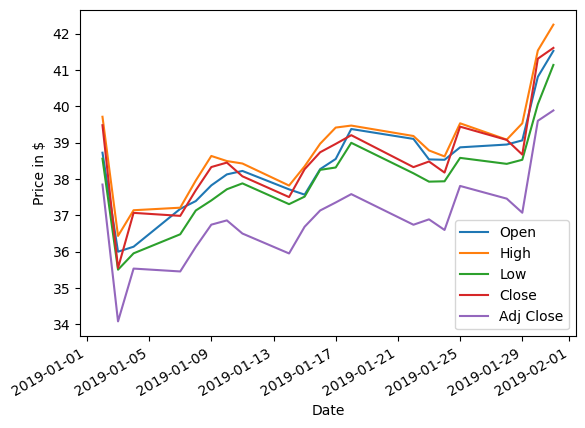

In [4]:
aapl_data.head(n=21).drop(columns=['Volume']).plot(), plt.ylabel('Price in $');

The dataset contains no missing values:

In [5]:
print('Number of missing values in the data:', aapl_data.isnull().sum().sum())

Number of missing values in the data: 0


Let us now visualize the time series of the adjusted closing prices.

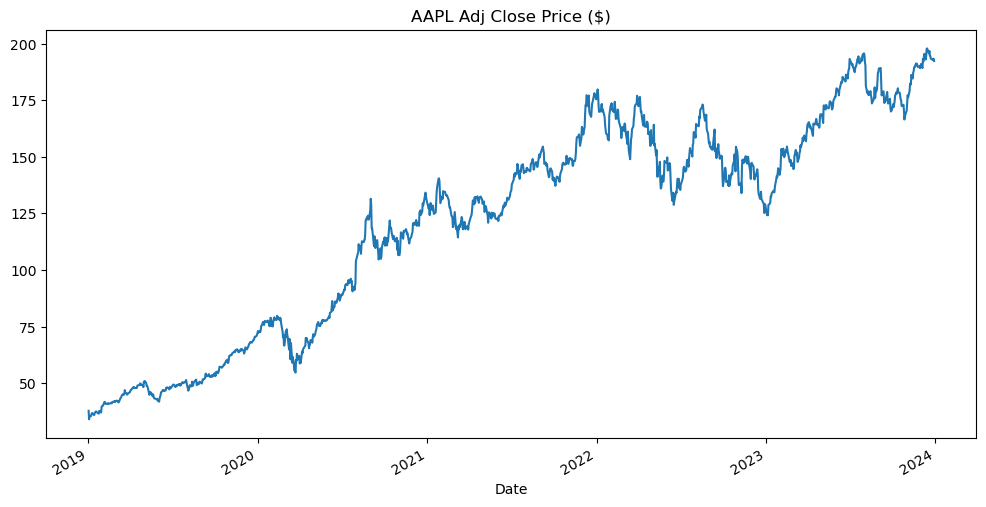

In [6]:
# plot the adjusted close price
aapl_data['Adj Close'].plot(title='AAPL Adj Close Price ($)', figsize=(12, 6));

An interesting visualization would be to look at the differentiated series, that is - the series of the differences between consecutvie days.

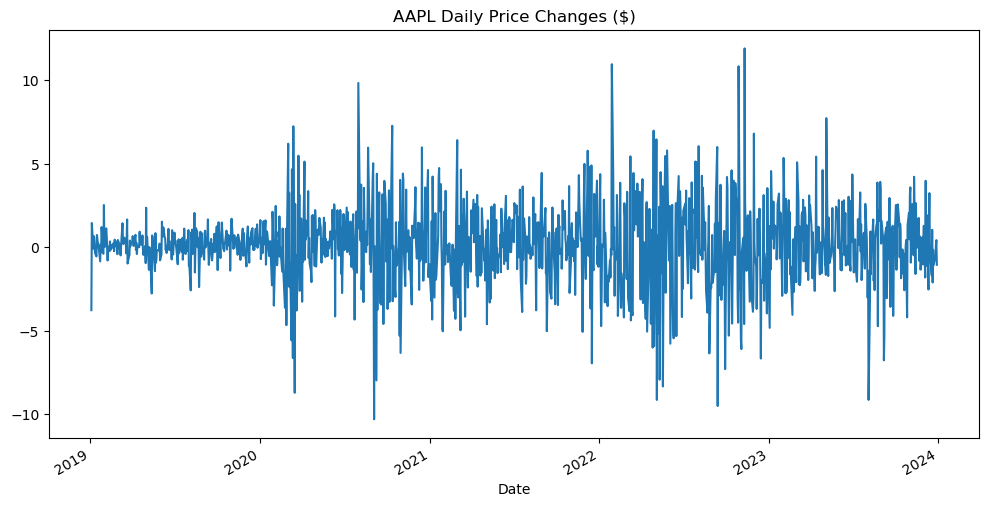

In [7]:
# Calculate and plot the series of the differences between consecutive days
diff_series = aapl_data['Adj Close'].diff().dropna()
diff_series.plot(title='AAPL Daily Price Changes ($)', figsize=(12, 6));

To wrap up the EDA section, let us visualize the last variable from our dataset that we hvae not yet dicussed - the 'Volume' variable. This variable represents the number of shares traded during the trading day. As its time series is more fluctating, we find it more informative to look at one specific year, for example 2023.

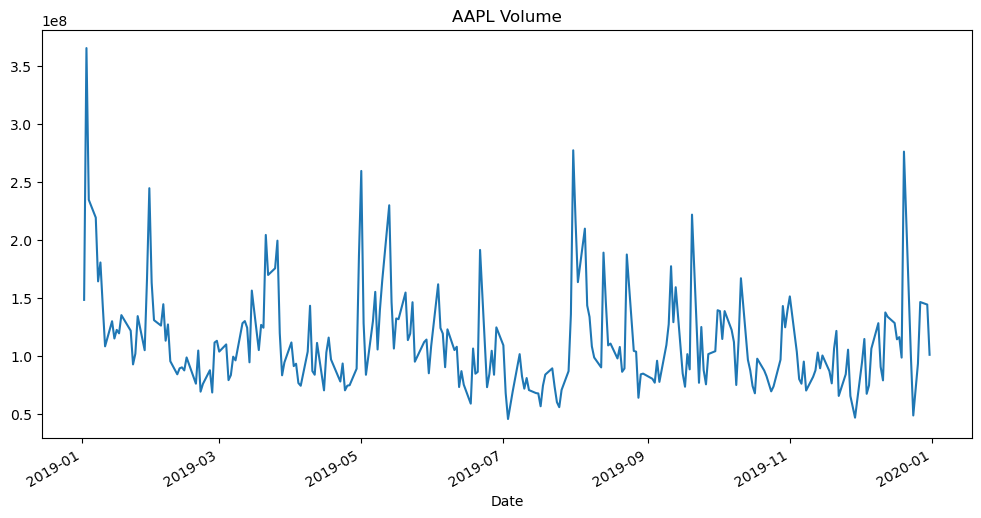

In [8]:
aapl_2023 = aapl_data[aapl_data.index.year == 2019]  # keep only the data for 2023
aapl_2023['Volume'].plot(title='AAPL Volume', figsize=(12, 6));  # plot the volume

## One-day-ahead forecasts

### SARIMA

Note - We fit the model on the train set and predict on the test set.

In [9]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_adj_close = aapl_data['Adj Close']

# Split data into train and test sets
train_size = int(len(aapl_adj_close) * TRAIN_PROPORTION)
TEST_SIZE = len(aapl_adj_close) - train_size
train, test = aapl_adj_close[0:train_size], aapl_adj_close[train_size:]

# Use auto_arima to find the best SARIMA model, setting m to 5 for weekly seasonality
SARIMA_model = auto_arima(train, start_p=0, d=None, start_q=0,
                          max_p=5, max_d=5, max_q=5, start_P=0,
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=5, seasonal=True,
                          error_action='warn', trace=True,
                          suppress_warnings=True, stepwise=True,
                          random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=6053.427, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=4954.070, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=5470.661, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=6060.413, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=5129.621, Time=0.19 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=4866.054, Time=0.38 sec
 ARIMA(1,0,0)(3,1,0)[5] intercept   : AIC=4822.933, Time=0.63 sec
 ARIMA(1,0,0)(4,1,0)[5] intercept   : AIC=4781.881, Time=1.02 sec
 ARIMA(1,0,0)(5,1,0)[5] intercept   : AIC=4763.407, Time=1.73 sec
 ARIMA(1,0,0)(5,1,1)[5] intercept   : AIC=inf, Time=5.84 sec
 ARIMA(1,0,0)(4,1,1)[5] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(0,0,0)(5,1,0)[5] intercept   : AIC=6060.640, Time=1.22 sec
 ARIMA(2,0,0)(5,1,0)[5] intercept   : AIC=4764.921, Time=1.97 sec
 ARIMA(1,0,1)(5,1,0)[5] intercept   : AIC=4764.918, Time=1.85 sec
 ARIMA(0,0,1)(5,1,0)[5] intercept   : AIC=5

Based on our training data and our selected seasonality of 5 days, the optimal (in terms of minimizing AIC) SARIMA model for our data is ARIMA(1,0,0)(5,1,0)[5]. We chose a 5-day seasonality because we believe the data exhibits weekly patterns, and since it includes only business days, each week consists of 5 days (or fewer, in the case of holidays).

In [10]:
# Fit SARIMAX model using the best parameters found
sarimax_model = SARIMAX(train, order=SARIMA_model.order, seasonal_order=SARIMA_model.seasonal_order)
fitted_sarimax_model = sarimax_model.fit(disp=False)

# Now, let's forecast step-by-step and update the model with new data points
SARIMA_test_predictions = []
for new_point in test:
    # Forecast the next point
    forecast = fitted_sarimax_model.forecast()
    SARIMA_test_predictions.append(forecast.item())

    # Update the model with the actual new observation
    fitted_sarimax_model = fitted_sarimax_model.append([new_point], refit=False)

# Calculate the RMSE
one_day_ahead_RMSE.loc['SARIMA'] = rmse(test, SARIMA_test_predictions, squared=False)

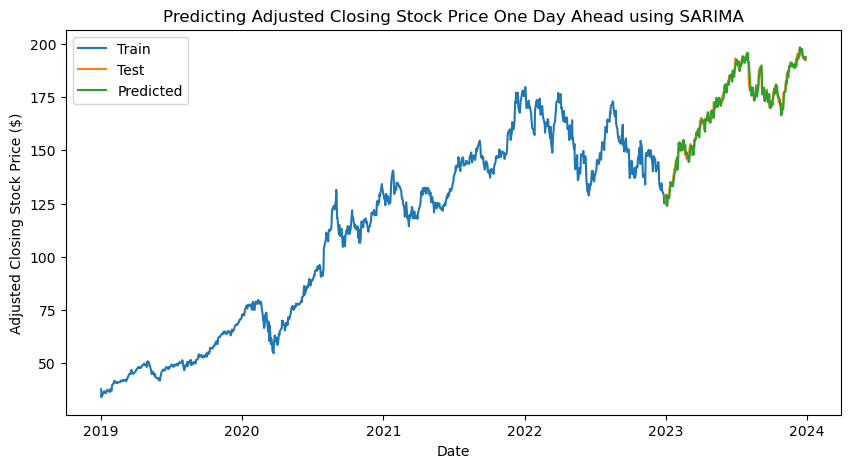

In [11]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, SARIMA_test_predictions, label='Predicted')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)')
plt.title('Predicting Adjusted Closing Stock Price One Day Ahead using SARIMA')
plt.legend(), plt.show();

In [12]:
print("SARIMA Model Summary:")
p, d, q = fitted_sarimax_model.specification.order
P, D, Q, s = fitted_sarimax_model.specification.seasonal_order

# Printing the model configuration
print(f"SARIMA model order: ({p},{d},{q})({P},{D},{Q})[{s}]")
print("The fitted model parameters:")
fitted_sarimax_model.summary().tables[1]

SARIMA Model Summary:
SARIMA model order: (1,0,0)(5,1,0)[5]
The fitted model parameters:


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9394,0.010,98.409,0.000,0.921,0.958
ar.S.L5,-0.7299,0.025,-28.851,0.000,-0.779,-0.680
ar.S.L10,-0.5993,0.033,-18.315,0.000,-0.663,-0.535
ar.S.L15,-0.4467,0.034,-13.050,0.000,-0.514,-0.380
ar.S.L20,-0.3174,0.032,-9.782,0.000,-0.381,-0.254
ar.S.L25,-0.1455,0.026,-5.602,0.000,-0.196,-0.095
sigma2,6.6918,0.200,33.501,0.000,6.300,7.083


#### SARIMA + Other Variables of the Dataset + Dollar Data

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=6053.427, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=4954.070, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=5470.661, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=6060.413, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=5129.621, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=4866.054, Time=0.40 sec
 ARIMA(1,0,0)(3,1,0)[5] intercept   : AIC=4822.933, Time=0.63 sec
 ARIMA(1,0,0)(4,1,0)[5] intercept   : AIC=4781.881, Time=1.08 sec
 ARIMA(1,0,0)(5,1,0)[5] intercept   : AIC=4763.407, Time=1.75 sec
 ARIMA(1,0,0)(5,1,1)[5] intercept   : AIC=inf, Time=6.10 sec
 ARIMA(1,0,0)(4,1,1)[5] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,0,0)(5,1,0)[5] intercept   : AIC=6060.640, Time=1.27 sec
 ARIMA(2,0,0)(5,1,0)[5] intercept   : AIC=4764.921, Time=1.83 sec
 ARIMA(1,0,1)(5,1,0)[5] intercept   : AIC=4764.918, Time=1.88 sec
 ARIMA(0,0,1)(5,1,0)[5] intercept   : AIC=5

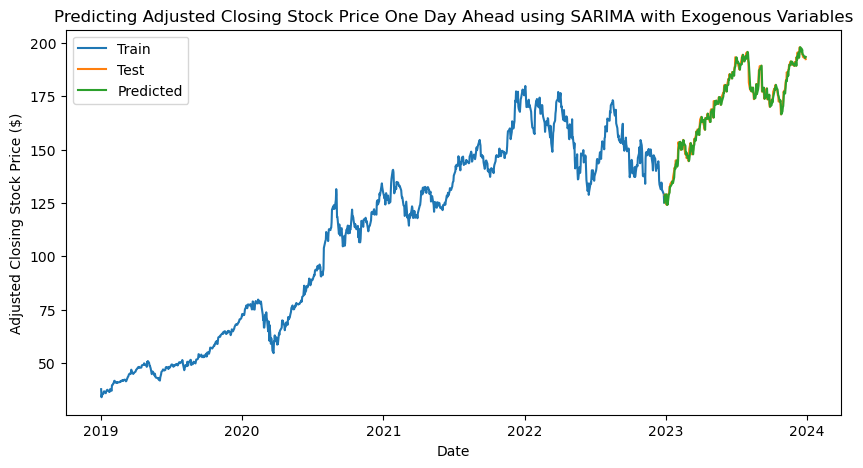

In [13]:
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
dollar_data = yf.download('DX-Y.NYB', start='2019-01-01', end='2024-01-01', progress=False)

# change the name of the columns so we can do join later
aapl_data.columns = ['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Adj Close', 'AAPL_Volume']
dollar_data.columns = ['Dollar_Open', 'Dollar_High', 'Dollar_Low', 'Dollar_Close', 'Dollar_Adj Close', 'Dollar_Volume']

# join the dataframes
joined_aapl_dolar_data = aapl_data.join(dollar_data, how='inner')

# split to train and test
train_size = int(len(joined_aapl_dolar_data) * TRAIN_PROPORTION)
joined_train, joined_test = joined_aapl_dolar_data[0:train_size], joined_aapl_dolar_data[train_size:]

# fit a model to the data
SARIMA_exogenous_model = auto_arima(joined_train['AAPL_Adj Close'], exogenous=joined_train.drop(columns=['AAPL_Adj Close']), start_p=0, d=None, start_q=0,
                                    max_p=5, max_d=5, max_q=5, start_P=0,
                                    D=1, start_Q=0, max_P=5, max_D=5,
                                    max_Q=5, m=5, seasonal=True,
                                    error_action='warn', trace=True,
                                    suppress_warnings=True, stepwise=True,
                                    random_state=20, n_fits=50)

# Fit SARIMAX model using the best parameters found
sarimax_exogenous_model = SARIMAX(joined_train['AAPL_Adj Close'], exog=joined_train.drop(
    columns=['AAPL_Adj Close']), order=SARIMA_exogenous_model.order, seasonal_order=SARIMA_exogenous_model.seasonal_order)
fitted_sarimax_exogenous_model = sarimax_exogenous_model.fit(disp=False)

# Now, let's forecast step-by-step and update the model with new data points
SARIMA_exogenous_test_predictions = []
previous_exog = joined_train[-1:].drop(columns=['AAPL_Adj Close'])
for i in range(len(joined_test)):
    new_point = joined_test.iloc[i]
    exog = new_point.drop('AAPL_Adj Close')
    # Forecast the next point
    forecast = fitted_sarimax_exogenous_model.forecast(steps=1, exog=[previous_exog])
    SARIMA_exogenous_test_predictions.append(forecast.item())

    # Update the model with the actual new observation
    fitted_sarimax_exogenous_model = fitted_sarimax_exogenous_model.append(
        [new_point['AAPL_Adj Close']], exog=[exog], refit=False)
    previous_exog = exog

# Calculate the RMSE
one_day_ahead_RMSE.loc['SARIMA Exogenous'] = rmse(
    joined_test['AAPL_Adj Close'], SARIMA_exogenous_test_predictions, squared=False)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(joined_train.index, joined_train['AAPL_Adj Close'], label='Train')
plt.plot(joined_test.index, joined_test['AAPL_Adj Close'], label='Test')
plt.plot(joined_test.index, SARIMA_exogenous_test_predictions, label='Predicted')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)'),
plt.title('Predicting Adjusted Closing Stock Price One Day Ahead using SARIMA with Exogenous Variables')
plt.legend(), plt.show();

### Prophet model

In [ ]:
from prophet import Prophet
from prophet.serialize import model_to_json
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# Download AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_adj_close = aapl_data['Adj Close'].reset_index()
aapl_adj_close.columns = ['ds', 'y']  # Prophet requires the column names to be ds and y

# Split data into train and test sets
train_size = int(len(aapl_adj_close) * TRAIN_PROPORTION)
train = aapl_adj_close.iloc[:train_size]
test = aapl_adj_close.iloc[train_size:]

# Initial model fit
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train)

# Save the initial model parameters
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))

# Initialize predictions list
prophet_test_predictions = []

# Loop through each point in the test data, predict, update model, and re-fit
for index, row in test.iterrows():
    # Load the initial model for a warm start (though Prophet does not directly support warm starting)
    with open('serialized_model.json', 'r') as fin:
        model_params = fin.read()

    # Instantiate a new Prophet model and fit to the extended data
    warm_model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    current_data = pd.concat([train, test.iloc[:index - train_size + 1]])  # including current point
    warm_model.fit(current_data)

    # Make prediction for the next day
    future = warm_model.make_future_dataframe(periods=1, freq='D')
    forecast = warm_model.predict(future)
    next_day_prediction = forecast.iloc[-1]['yhat']
    prophet_test_predictions.append(next_day_prediction)

# Calculate the RMSE
one_day_ahead_RMSE.loc['Prophet'] = rmse(test['y'], prophet_test_predictions, squared=False)

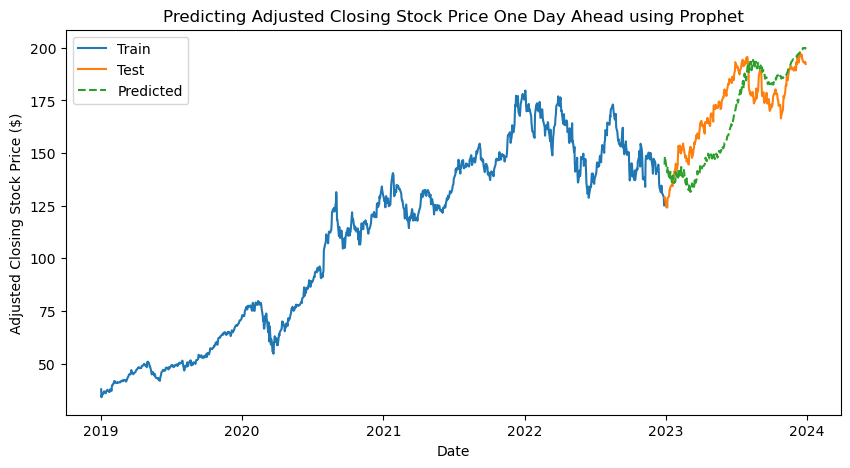

In [15]:
# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train['ds'], train['y'], label='Train')
ax.plot(test['ds'], test['y'], label='Test')
ax.plot(test['ds'], prophet_test_predictions, label='Predicted', linestyle='--')
ax.set_title('Predicting Adjusted Closing Stock Price One Day Ahead using Prophet')
ax.set_xlabel('Date'), ax.set_ylabel('Adjusted Closing Stock Price ($)')
ax.legend(), plt.show();

### Kalman Filter

Kalman Filter is great for Online Learning. We use it to predict the next price given all the previous prices without any training set.

In [16]:
from pykalman import KalmanFilter

# Download AAPL stock data
data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
prices = data['Adj Close'].values

# Initialize the Kalman Filter
initial_state_mean, initial_state_covariance = prices[0], 1
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  observation_covariance=1,
                  transition_covariance=.01)

# Initialize state using the first observation
state_mean, state_covariance = initial_state_mean, initial_state_covariance

# Predict and update using Kalman Filter with each new observation
KF_predictions = []

for price in prices:
    # Prediction step: predict the next state without the current observation
    predicted_state_mean, predicted_state_covariance = kf.filter_update(
        state_mean, state_covariance, observation=None
    )
    KF_predictions.append(predicted_state_mean[0].item())

    # Update step: update the filter with the actual observation
    state_mean, state_covariance = kf.filter_update(
        state_mean, state_covariance, observation=price
    )

# Calculate the RMSE for the test set
train_size = int(len(prices) * TRAIN_PROPORTION)  # even though we do not really have train here
test_KF_predictions = KF_predictions[train_size:]
test_prices = prices[train_size:]
one_day_ahead_RMSE.loc['Kalman Filter'] = rmse(test_prices, test_KF_predictions, squared=False)

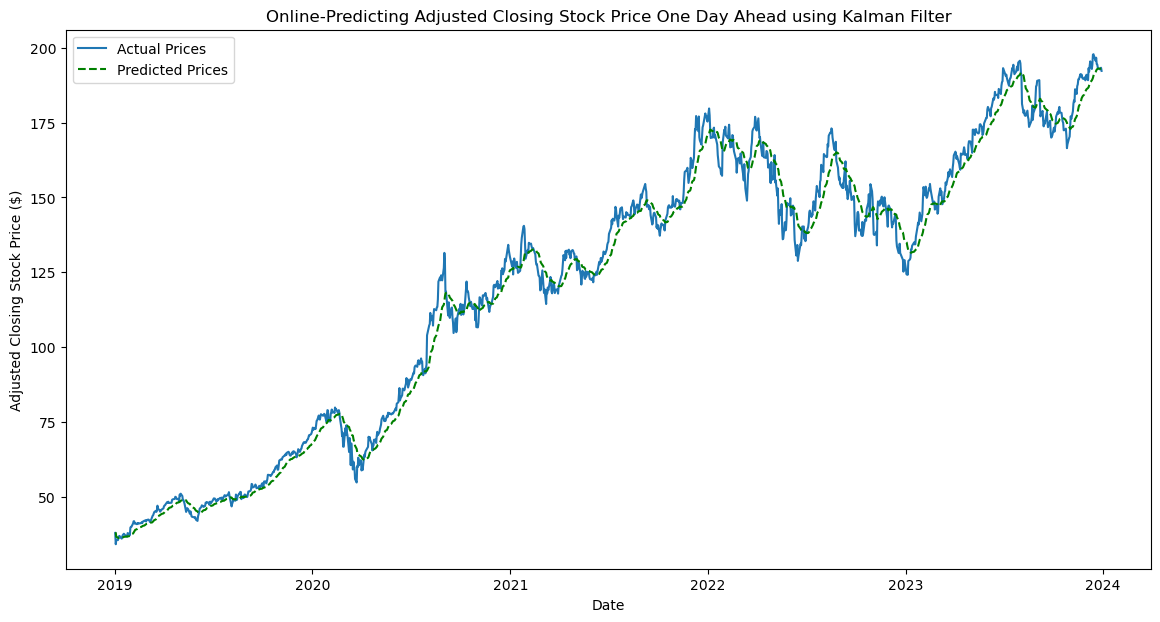

(<matplotlib.legend.Legend at 0x1e91458c680>, None)

In [17]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'].index, prices, label='Actual Prices')
plt.plot(data['Adj Close'].index, KF_predictions, color='green', label='Predicted Prices', linestyle='--')
plt.title('Online-Predicting Adjusted Closing Stock Price One Day Ahead using Kalman Filter')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)')
plt.legend(), plt.show()

#### Multivariate Kalman Filter - Incorporating the Other Variables of the Dataset

Though the adjusted closing price is the acceptable variable used to analyze stock prices, the dataset contains 4 more variables - let us check if incorporating them can help Kalman Filter predict better.

In [18]:
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
dollar_data = yf.download('DX-Y.NYB', start='2019-01-01', end='2024-01-01', progress=False)

# change the name of the columns so we can do join later
aapl_data.columns = ['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Adj Close', 'AAPL_Volume']
dollar_data.columns = ['Dollar_Open', 'Dollar_High', 'Dollar_Low', 'Dollar_Close', 'Dollar_Adj Close', 'Dollar_Volume']

# join the dataframes
multi_variavte_data = aapl_data.join(dollar_data, how='inner')

# The features for the Kalman Filter model (all the features in AAPL's dataset):
features = ['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Adj Close', 'AAPL_Volume',
            'Dollar_Open', 'Dollar_High', 'Dollar_Low', 'Dollar_Close', 'Dollar_Adj Close', 'Dollar_Volume']
observations = multi_variavte_data[features]

# Prepare initial state based on the first observation
initial_state_mean = observations.iloc[0]
initial_state_covariance = np.eye(len(features))

# Initialize the Kalman Filter for multivariate observations
kf_all_features = KalmanFilter(transition_matrices=np.eye(len(features)),
                               observation_matrices=np.eye(len(features)),
                               initial_state_mean=initial_state_mean,
                               initial_state_covariance=initial_state_covariance,
                               observation_covariance=np.eye(len(features)) * 1,
                               transition_covariance=np.eye(len(features)) * .01)


state_means, state_covariances = initial_state_mean, initial_state_covariance

# Extract the estimates for 'Adj Close'
multivariate_KF_predictions = []
for idx, observation in observations.iterrows():
    # predict:
    state_means, state_covariances = kf_all_features.filter_update(state_means, state_covariances, observation=None)
    multivariate_KF_predictions.append(state_means[features.index('AAPL_Adj Close')])

    # update:
    state_means, state_covariances = kf_all_features.filter_update(
        state_means, state_covariances, observation=observation)


# Calculate the RMSE
test_multivariate_KF_predictions = multivariate_KF_predictions[train_size:]
test_prices = prices[train_size:]
one_day_ahead_RMSE.loc['Multivariate Kalman Filter'] = rmse(
    test_prices, test_multivariate_KF_predictions, squared=False)

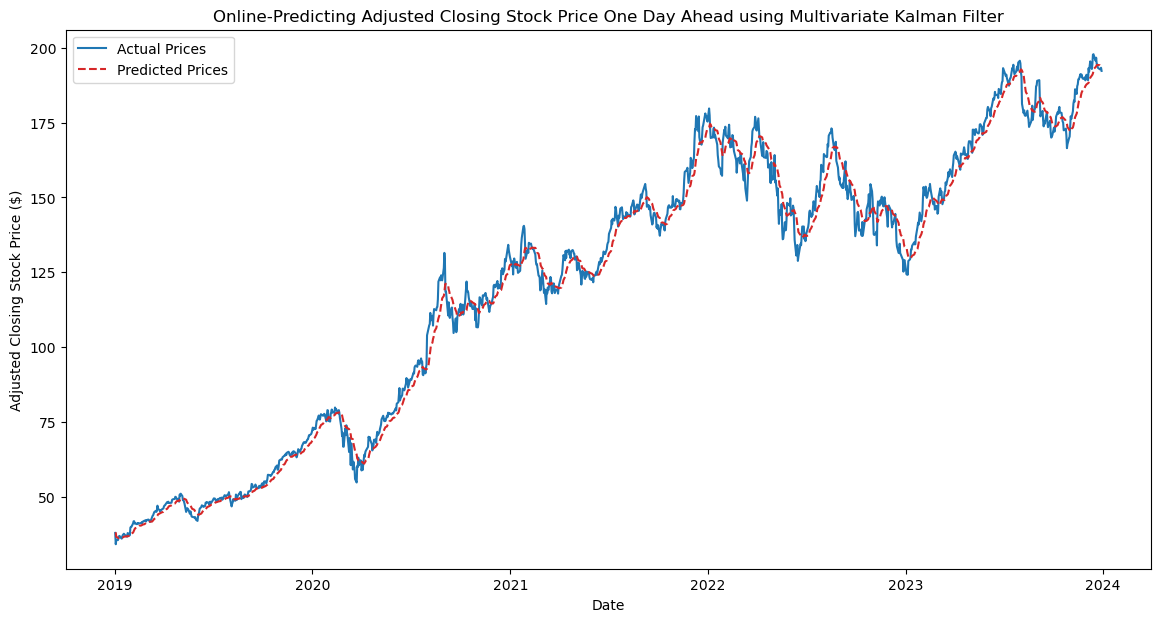

(<matplotlib.legend.Legend at 0x1e9149cca10>, None)

In [19]:
# the 4th color in matplotlib's default color cycle:
fourth_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

# Step 4: Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, multi_variavte_data['AAPL_Adj Close'], label='Actual Prices')
plt.plot(data.index, multivariate_KF_predictions, color=fourth_color, label='Predicted Prices', linestyle='--')
plt.title('Online-Predicting Adjusted Closing Stock Price One Day Ahead using Multivariate Kalman Filter')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)')
plt.legend(), plt.show()

#### So is incorporating all features beneficial? Let's visualize the difference then quantify it.

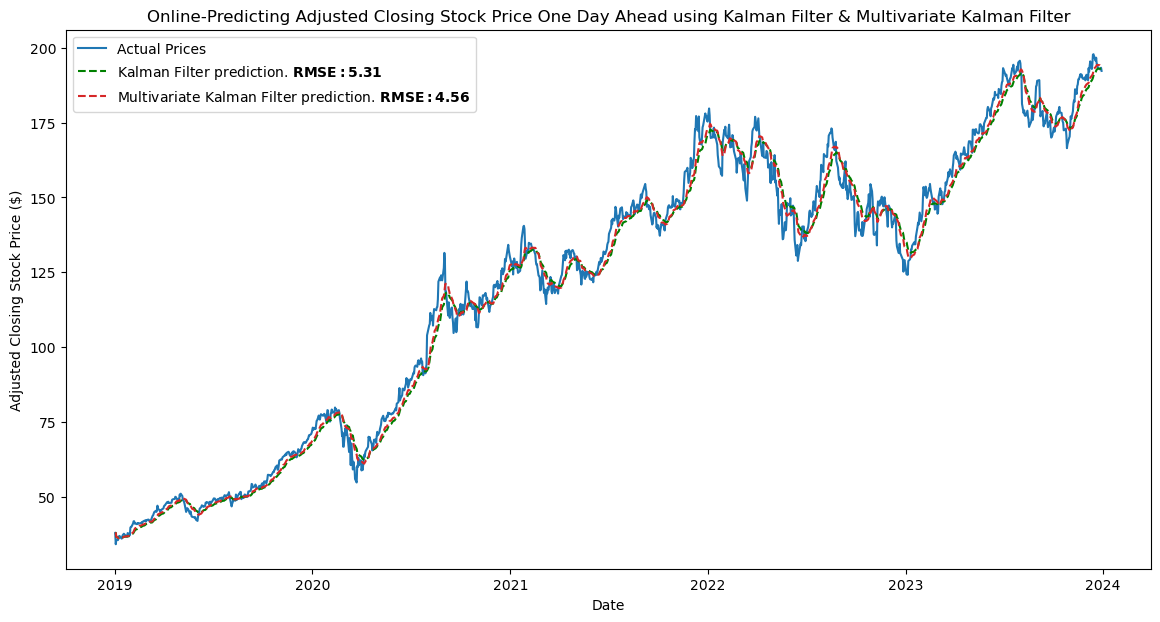

(<matplotlib.legend.Legend at 0x1e914981a90>, None)

In [20]:
# Create the plot
RMSE_multivariate_kalman = rmse(multi_variavte_data['AAPL_Adj Close'], multivariate_KF_predictions, squared=False)
RMSE_kalman = rmse(data['Adj Close'], KF_predictions, squared=False)
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Adj Close'], label='Actual Prices')
plt.plot(data.index, KF_predictions, color='green',
         label='Kalman Filter prediction. $\\mathbf{{RMSE: %.2f}}$' % RMSE_kalman, linestyle='--')
plt.plot(data.index, multivariate_KF_predictions, color=fourth_color,
         label='Multivariate Kalman Filter prediction. $\\mathbf{{RMSE: %.2f}}$' % RMSE_multivariate_kalman, linestyle='--')
plt.title('Online-Predicting Adjusted Closing Stock Price One Day Ahead using Kalman Filter & Multivariate Kalman Filter')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)')
plt.legend(), plt.show()

So adding all the available features does help.

Note: The RMSEs reported in the above plot are calculated on the entire dataset (2019-2024). The RMSEs reported later are the RMSEs calculated only on the period which is the test set for the other models (last year or so).

### LSTM - Long Short Term Memory

In [21]:
AAPL_values = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)

# convert the Date column into a pandas datatime format
AAPL_values.index = pd.to_datetime(AAPL_values.index)

scaler = MinMaxScaler(feature_range=(0, 1))
AAPL_values['Adj Close'] = scaler.fit_transform(AAPL_values[['Adj Close']])

# train / test split
train_data = AAPL_values[:int(0.8*len(AAPL_values))].reset_index(drop=False)
test_data = AAPL_values[int(0.8*len(AAPL_values)):].reset_index(drop=False)

X_train = train_data.Date
y_train = train_data['Adj Close']
X_test = test_data.Date
y_test = test_data['Adj Close']


n_features = 1
train_series = y_train.values.reshape((len(y_train), n_features))
test_series = y_test.values.reshape((len(y_test), n_features))


look_back = 20
x_days_ahead = 1

train_generator = TimeseriesGenerator(train_series[:len(train_series) - x_days_ahead + 1], train_series[x_days_ahead - 1:],
                                      length=look_back,
                                      sampling_rate=1,
                                      stride=1,
                                      batch_size=10)

test_generator = TimeseriesGenerator(test_series[:len(test_series)-x_days_ahead+1], test_series[x_days_ahead-1:],
                                     length=look_back,
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=10)

In [22]:
look_back = 20  # ensure this is defined, same with n_features
n_features = 1  # example value, set this according to your actual data features
n_neurons = 4

model = Sequential()
model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.fit(train_generator, epochs=300, verbose=0);

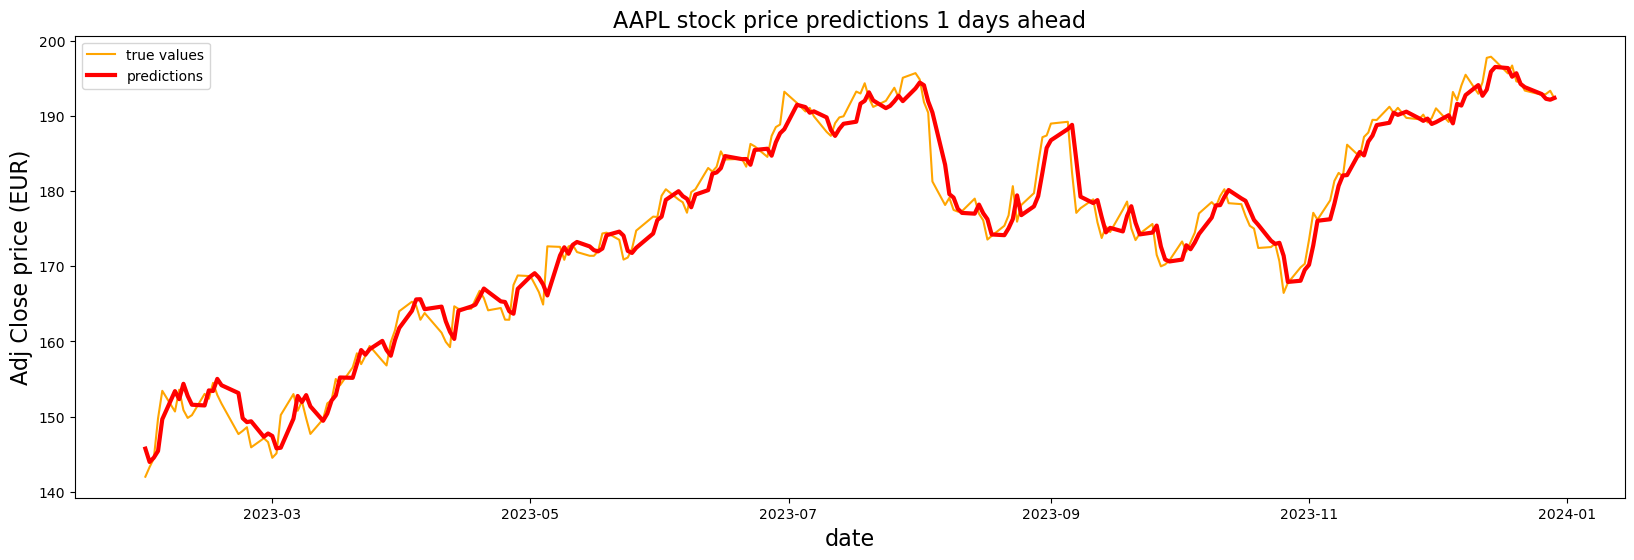

In [23]:
test_predictions = model.predict(test_generator, verbose=0)

inverted_scale_predictions = scaler.inverse_transform(test_predictions)
inverted_scale_test = scaler.inverse_transform(test_series[look_back + x_days_ahead - 1:])
LSTM_y_test_pred = inverted_scale_predictions

plt.figure(figsize=(20, 6))
plt.plot(test_data.Date[look_back + x_days_ahead - 1:], inverted_scale_test, c='orange', label='true values')
plt.plot(test_data.Date[look_back + x_days_ahead - 1:], inverted_scale_predictions,
         lw=3, c='r', linestyle='-', label='predictions')
plt.xlabel("date", fontsize=16)
plt.ylabel("Adj Close price (EUR)", fontsize=16)
plt.title(f"AAPL stock price predictions {x_days_ahead} days ahead", fontsize=16);
plt.legend(), plt.show();

In [24]:
score = rmse(inverted_scale_test, inverted_scale_predictions, squared=False)
print('Test RMSE: %.3f' % score)
one_day_ahead_RMSE.loc['LSTM'] = score

Test RMSE: 2.257


#### LSTM + Using Exogenous Data
We will use the dollar price as an exogenous variable.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

np.random.seed(42)
tensorflow.random.set_seed(42)

# Fetch data from Yahoo Finance
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
dollar_data = yf.download('DX-Y.NYB', start='2019-01-01', end='2024-01-01', progress=False)

# save to a new dataframe only the Adjusted Close prices
aapl_open = aapl_data['Open']
aapl_close = aapl_data['Close']
aapl_high = aapl_data['High']
aapl_low = aapl_data['Low']
aapl_volume = aapl_data['Volume']
aapl_adj_close = aapl_data['Adj Close']
dollar_open = dollar_data['Open']
dollar_close = dollar_data['Close']
dollar_high = dollar_data['High']
dollar_low = dollar_data['Low']
dollar_volume = dollar_data['Volume']
dollar_adj_close = dollar_data['Adj Close']


scaler = MinMaxScaler(feature_range=(0, 1))
aapl_open_scaled = scaler.fit_transform(aapl_open.values.reshape(-1, 1))
aapl_close_scaled = scaler.fit_transform(aapl_close.values.reshape(-1, 1))
aapl_high_scaled = scaler.fit_transform(aapl_high.values.reshape(-1, 1))
aapl_low_scaled = scaler.fit_transform(aapl_low.values.reshape(-1, 1))
aapl_volume_scaled = scaler.fit_transform(aapl_volume.values.reshape(-1, 1))

dollar_open_scaled = scaler.fit_transform(dollar_open.values.reshape(-1, 1))
dollar_close_scaled = scaler.fit_transform(dollar_close.values.reshape(-1, 1))
dollar_high_scaled = scaler.fit_transform(dollar_high.values.reshape(-1, 1))
dollar_low_scaled = scaler.fit_transform(dollar_low.values.reshape(-1, 1))
dollar_volume_scaled = scaler.fit_transform(dollar_volume.values.reshape(-1, 1))
dollar_adj_close_scaled = scaler.fit_transform(dollar_adj_close.values.reshape(-1, 1))

# adj_close is last here so that later we can use "scaler" to inverse transform the predictions
aapl_adj_close_scaled = scaler.fit_transform(aapl_adj_close.values.reshape(-1, 1))

combined_data = pd.concat([pd.DataFrame(aapl_open_scaled), pd.DataFrame(aapl_high_scaled), pd.DataFrame(aapl_low_scaled), pd.DataFrame(aapl_close_scaled), pd.DataFrame(aapl_volume_scaled), pd.DataFrame(
    aapl_adj_close_scaled), pd.DataFrame(dollar_open_scaled), pd.DataFrame(dollar_high_scaled), pd.DataFrame(dollar_low_scaled), pd.DataFrame(dollar_close_scaled), pd.DataFrame(dollar_volume_scaled)], axis=1)
combined_data.index = pd.to_datetime(combined_data.index)

# Split data into training and testing
train_data = combined_data[:int(0.8 * len(combined_data))]
test_data = combined_data[int(0.8 * len(combined_data)):]

In [26]:
# Prepare data for LSTM
n_features = combined_data.shape[1]  # Number of features
look_back = 20
x_days_ahead = 1

train_series = train_data.values
train_target_series = train_data.iloc[:, 5].values
test_series = test_data.values
test_target_series = test_data.iloc[:, 5].values

train_generator = TimeseriesGenerator(train_series[:len(train_series) - x_days_ahead + 1], train_target_series[x_days_ahead - 1:],
                                      length=look_back, sampling_rate=1, stride=1, batch_size=10)
test_generator = TimeseriesGenerator(test_series[:len(test_series) - x_days_ahead + 1], test_target_series[x_days_ahead - 1:],
                                     length=look_back, sampling_rate=1, stride=1, batch_size=10)

# LSTM Model
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Fit model
model.fit(train_generator, epochs=300, verbose=0)

# Predictions
test_predictions = model.predict(test_generator, verbose=0)

In [27]:
AAPL_values = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)

# convert the Date column into a pandas datatime format
AAPL_values.index = pd.to_datetime(AAPL_values.index)

# train / test split
train_data = AAPL_values[:int(0.8*len(AAPL_values))].reset_index(drop=False)
test_data = AAPL_values[int(0.8*len(AAPL_values)):].reset_index(drop=False)

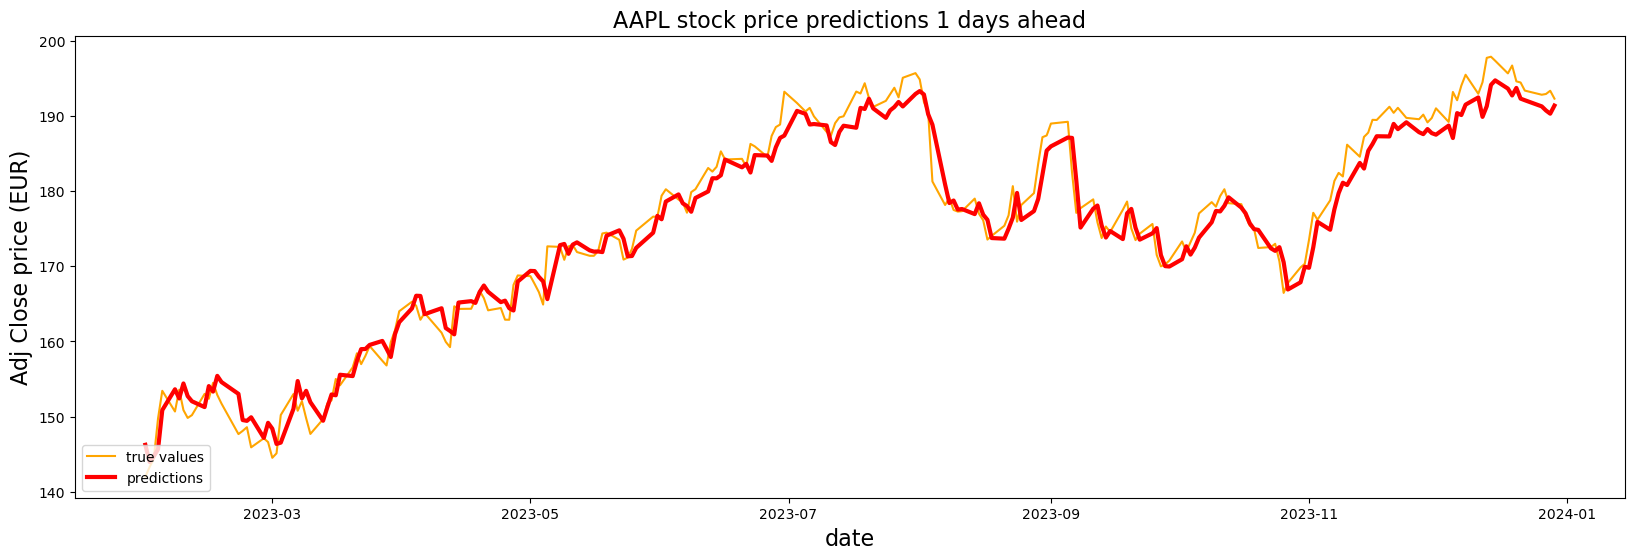

In [28]:
inverted_scale_predictions = scaler.inverse_transform(test_predictions)
inverted_scale_test = scaler.inverse_transform(test_target_series[look_back + x_days_ahead - 1:].reshape(-1, 1))
LSTM_EX_y_test_pred = inverted_scale_predictions

plt.figure(figsize=(20, 6))
plt.plot(test_data.Date[look_back + x_days_ahead - 1:], inverted_scale_test, c='orange', label='true values')
plt.plot(test_data.Date[look_back + x_days_ahead - 1:], inverted_scale_predictions,
         lw=3, c='r', linestyle='-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Adj Close price (EUR)", fontsize=16)
plt.title(f"AAPL stock price predictions {x_days_ahead} days ahead", fontsize=16);

In [29]:
inverted_scale_predictions = scaler.inverse_transform(test_predictions)
inverted_scale_test = scaler.inverse_transform(test_target_series[look_back + x_days_ahead - 1:].reshape(-1, 1))

score = rmse(inverted_scale_test, inverted_scale_predictions, squared=False)
print('Test RMSE: %.3f' % score)
one_day_ahead_RMSE.loc['LSTM Exogenous'] = score

Test RMSE: 2.479


#### So How Well Each Method Performed in One Day Ahead Predictions?

In [30]:
one_day_ahead_RMSE.sort_values(by='RMSE', inplace=True)
one_day_ahead_RMSE

,RMSE
SARIMA Exogenous,2.151244
LSTM,2.256573
SARIMA,2.329487
LSTM Exogenous,2.479359
Multivariate Kalman Filter,4.738375
Kalman Filter,5.591809
Prophet,14.560667


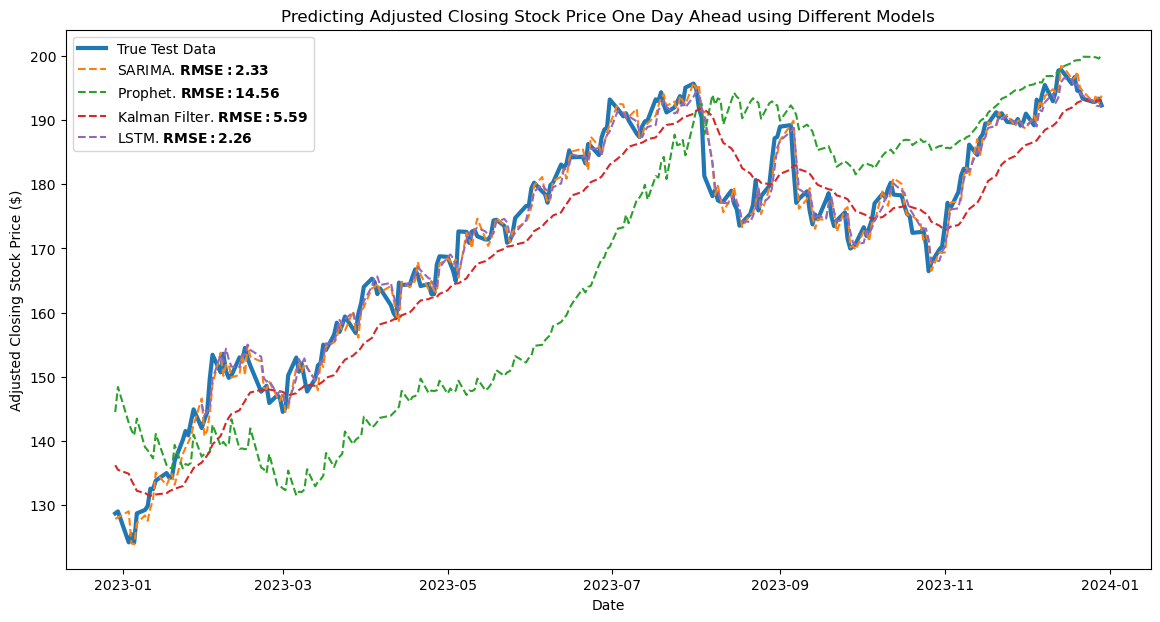

In [31]:
# plot the true test data and the test predictions of all models and display the RMSE in bold in the legend
# Download AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_adj_close = aapl_data['Adj Close'].reset_index()
aapl_adj_close.columns = ['ds', 'y']  # Prophet requires the column names to be ds and y

# Split data into train and test sets
train_size = int(len(aapl_adj_close) * TRAIN_PROPORTION)
train = aapl_adj_close.iloc[:train_size]
test = aapl_adj_close.iloc[train_size:]

plt.figure(figsize=(14, 7))
plt.plot(test['ds'], test['y'], label='True Test Data', linewidth=3)
plt.plot(test['ds'], SARIMA_test_predictions, linestyle='--',
         label='SARIMA. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['SARIMA'].values[0])
plt.plot(test['ds'], prophet_test_predictions, linestyle='--',
         label='Prophet. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['Prophet'].values[0])
plt.plot(test['ds'], test_KF_predictions, linestyle='--',
         label='Kalman Filter. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['Kalman Filter'].values[0])
plt.plot(test['ds'][20:], LSTM_y_test_pred, linestyle='--',
         label='LSTM. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['LSTM'].values[0])
plt.title('Predicting Adjusted Closing Stock Price One Day Ahead using Different Models')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)')
plt.legend(), plt.show();

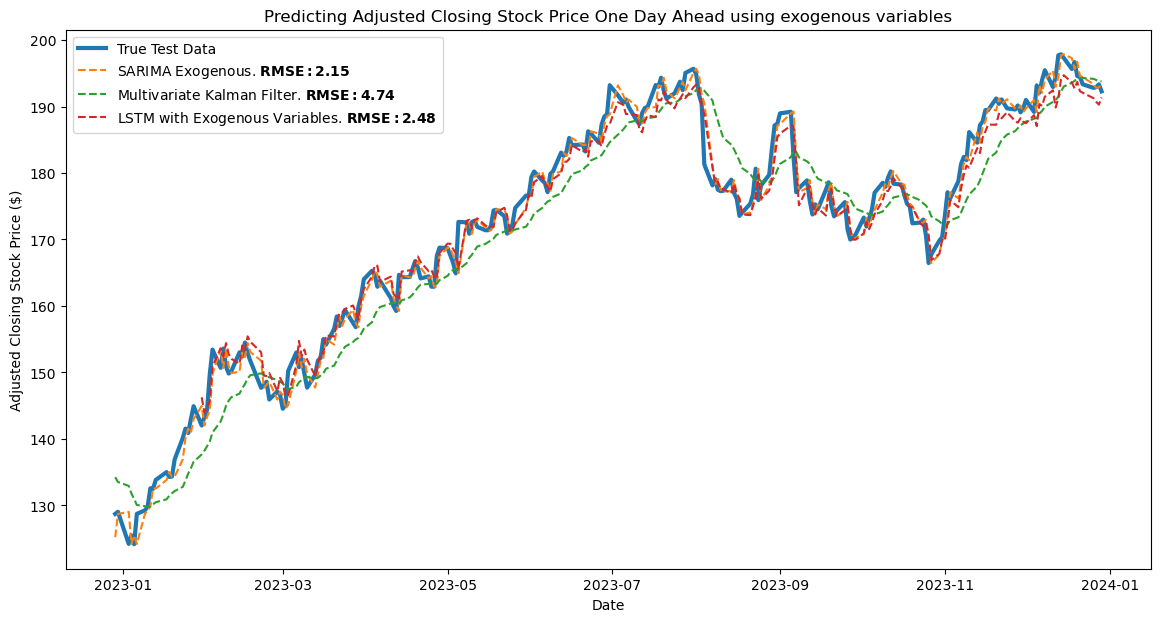

In [32]:
# plot the true test data and the test predictions of all models and display the RMSE in bold in the legend
# Download AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_adj_close = aapl_data['Adj Close'].reset_index()
aapl_adj_close.columns = ['ds', 'y']  # Prophet requires the column names to be ds and y

# Split data into train and test sets
train_size = int(len(aapl_adj_close) * TRAIN_PROPORTION)
train = aapl_adj_close.iloc[:train_size]
test = aapl_adj_close.iloc[train_size:]

plt.figure(figsize=(14, 7))
plt.plot(test['ds'], test['y'], label='True Test Data', linewidth=3)
plt.plot(test['ds'], SARIMA_exogenous_test_predictions, linestyle='--',
         label='SARIMA Exogenous. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['SARIMA Exogenous'].values[0])
plt.plot(test['ds'], test_multivariate_KF_predictions, linestyle='--',
         label='Multivariate Kalman Filter. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['Multivariate Kalman Filter'].values[0])
plt.plot(test['ds'][20:], LSTM_EX_y_test_pred, linestyle='--',
         label='LSTM with Exogenous Variables. $\\mathbf{RMSE: %.2f}$' % one_day_ahead_RMSE.loc['LSTM Exogenous'].values[0])
plt.title('Predicting Adjusted Closing Stock Price One Day Ahead using exogenous variables')
plt.xlabel('Date'), plt.ylabel('Adjusted Closing Stock Price ($)')
plt.legend(), plt.show();

We now have a view of the performance of the different models in one-day-ahead predictions. In particular, SARIMA outperforms all other models. An interesting follow-up question would be: how do the different models perform on the more difficult task of predicing $x > 1$ days ahead?

## Going Beyond Tommorow - Forecasting More than One Day Ahead

In [33]:
X_LIST = [1, 5, 10]  # Number of days ahead to predict
rmse_x_days_ahead_df = pd.DataFrame(columns=X_LIST)


def plot_predictions_and_compute_rmse(predictions_dict, method):
    plt.figure(figsize=(12, 8))
    rmse_dict = {}

    actual_plotted = False  # Flag to check if actual values have been plotted
    for x_days_ahead, (predictions, actuals) in predictions_dict.items():
        # Compute RMSE for each prediction set
        rmse_dict[x_days_ahead] = rmse(actuals, predictions, squared=False)

        # Plotting
        if not actual_plotted:
            plt.plot(actuals.index, actuals, label='Actual Values', color='blue')
            actual_plotted = True

        plt.plot(actuals.index, predictions, linestyle='--',
                 label=f'Predicted $\\mathbf{{{x_days_ahead}}}$ days ahead $\\mathbf{{RMSE: {rmse_dict[x_days_ahead]:.2f}}}$',
                 alpha=0.75)

    plt.title('Comparison of Multi-Day Forecasts Against Actual Values - ' + method)
    plt.xlabel('Date', fontsize=14), plt.ylabel('Adjusted Closing Stock Price ($)', fontsize=14)
    plt.legend(fontsize='x-large'), plt.show()

    return rmse_dict

### SARIMA

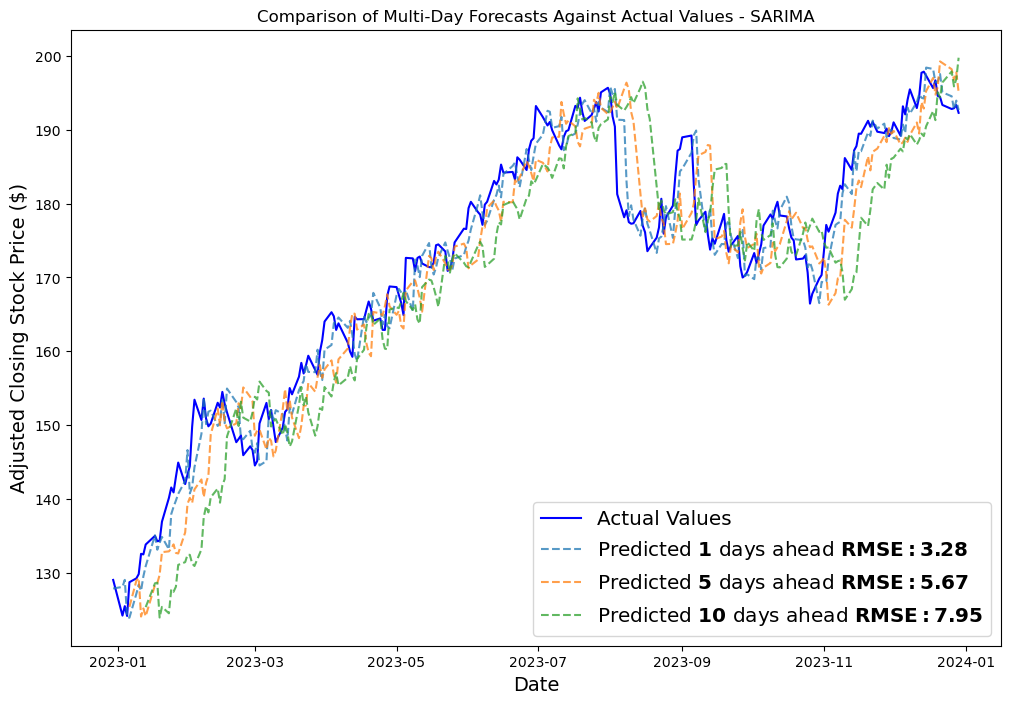

In [34]:
def incremental_sarima_forecast(train, test, order, seasonal_order, x_days_ahead):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)

    predictions = []
    for i in range(len(test) - x_days_ahead):
        future_forecast = fitted_model.get_forecast(steps=x_days_ahead)
        prediction = future_forecast.predicted_mean[-1]
        predictions.append(prediction)

        new_obs = test[i]  # Assume 'test' is an array-like structure
        fitted_model = fitted_model.append([new_obs], refit=False)

    return predictions


# Download AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_adj_close = aapl_data['Adj Close'].reset_index()
aapl_adj_close.columns = ['ds', 'y']

# Prepare data
train_size = int(len(aapl_adj_close) * TRAIN_PROPORTION)
train = aapl_adj_close['y'].iloc[:train_size].values
test = aapl_adj_close['y'].iloc[train_size:].values

# Fit SARIMAX model using auto_arima found parameters
# Use SARIMA_model.order and SARIMA_model.seasonal_order that we found earlier
sarimax_model = SARIMAX(train, order=SARIMA_model.order, seasonal_order=SARIMA_model.seasonal_order)
fitted_sarimax_model = sarimax_model.fit(disp=False)

predictions_dict = {}
for x_days_ahead in X_LIST:
    predicted_values = incremental_sarima_forecast(
        train, test, SARIMA_model.order, SARIMA_model.seasonal_order, x_days_ahead)
    actual_values = aapl_adj_close['y'].iloc[train_size + x_days_ahead:train_size +
                                             x_days_ahead + len(predicted_values)].reset_index(drop=True)
    dates = aapl_adj_close['ds'].iloc[train_size + x_days_ahead:train_size + x_days_ahead + len(predicted_values)]
    predictions_dict[x_days_ahead] = (pd.Series(predicted_values, index=dates),
                                      pd.Series(actual_values.values, index=dates))

# Plot the predictions and compute RMSE using the provided function
rmse_dict = plot_predictions_and_compute_rmse(predictions_dict, method='SARIMA')
for x in X_LIST:
    rmse_x_days_ahead_df.loc['SARIMA', x] = rmse_dict[x]

### Prophet

In [ ]:
import yfinance as yf
from prophet import Prophet

def get_model_params(model):
    """Retrieve parameters from a trained Prophet model."""
    return {
        'k': model.params['k'][0][0],
        'm': model.params['m'][0][0],
        'sigma_obs': model.params['sigma_obs'][0][0],
        'delta': model.params['delta'][0],
        'beta': model.params['beta'][0]
    }


def apply_warm_start(model, params):
    """Apply warm start to a Prophet model using saved parameters."""
    model.fit_kwargs['init'] = {
        'k': np.array([params['k']]),
        'm': np.array([params['m']]),
        'sigma_obs': np.array([params['sigma_obs']]),
        'delta': np.array([params['delta']]),
        'beta': np.array([params['beta']])
    }
    return model


def incremental_prophet_forecast(train, test, x_days_ahead, initial_params=None):
    model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    if initial_params:
        model = apply_warm_start(model, initial_params)
    model.verbose = False
    model.fit(train)

    predictions = []
    last_train_index = len(train) - 1

    for i in range(len(test)):
        future = model.make_future_dataframe(periods=x_days_ahead + i, freq='B')
        forecast = model.predict(future)
        if last_train_index + x_days_ahead + i < len(forecast):
            prediction = forecast.iloc[last_train_index + x_days_ahead + i]['yhat']
            predictions.append(prediction)

        new_point = pd.DataFrame({'ds': [test.iloc[i]['ds']], 'y': [test.iloc[i]['y']]})
        train = pd.concat([train, new_point], ignore_index=True)
        # Save model parameters before re-fitting
        params = get_model_params(model)
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
        model = apply_warm_start(model, params)
        model.fit(train)

    return predictions


# Download AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
aapl_adj_close = aapl_data['Adj Close'].reset_index()
aapl_adj_close.columns = ['ds', 'y']

# Split data into train and test sets
train_size = int(len(aapl_adj_close) * TRAIN_PROPORTION)
train = aapl_adj_close.iloc[:train_size]
test = aapl_adj_close.iloc[train_size:]

predictions_dict = {}
for x_days_ahead in X_LIST:
    predictions = incremental_prophet_forecast(train.copy(), test.copy(), x_days_ahead)
    actual_values = test['y'].iloc[:].reset_index(drop=True)[:len(predictions)]  
    dates = test['ds'].iloc[:][:len(predictions)] 
    predictions_dict[x_days_ahead] = (pd.Series(predictions, index=dates), pd.Series(actual_values.values, index=dates))

In [ ]:
# Plot predictions and compute RMSE using a given function
rmse_dict = plot_predictions_and_compute_rmse(predictions_dict, method='Prophet')
for x in X_LIST:
    rmse_x_days_ahead_df.loc['Prophet', x] = rmse_dict[x]

### Kalman Filter

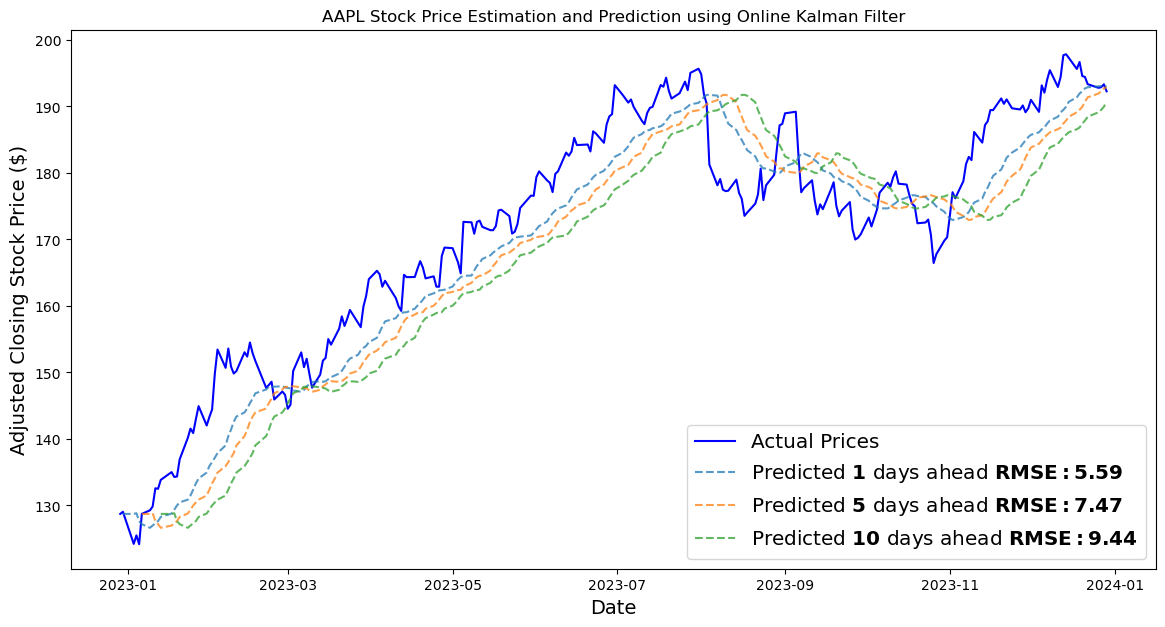

In [36]:
import yfinance as yf
from pykalman import KalmanFilter

def kalman_forecast(prices, x_days_ahead):
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=prices[0],
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Initialize state from training
    state_mean, state_covariance = prices[0], 1

    # Predictions list
    predictions = []
    actuals = []

    for i in range(len(prices) - x_days_ahead):

        # save the model without the demi-updates
        predicted_state_mean = state_mean
        predicted_state_covariance = state_covariance

        # Prediction step: demi-update the saved model without the current observation x_days_ahead times
        for _ in range(x_days_ahead):
            predicted_state_mean, predicted_state_covariance = kf.filter_update(
                predicted_state_mean, predicted_state_covariance, observation=None)

        # add the prediction to the list
        predictions.append(predicted_state_mean[0])
        actuals.append(prices[i+x_days_ahead-1])

        # update the model with the actual observation
        state_mean, state_covariance = kf.filter_update(
            state_mean, state_covariance, observation=prices[i]
        )

    return predictions, actuals


# Download AAPL data
data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)
prices = data['Adj Close'].values
test_starting_index = int(TRAIN_PROPORTION * len(prices))
test_data = prices[test_starting_index:]
test_dates = data.index[test_starting_index:]

# Forecasting for different days ahead
predictions_dict = {}
for x_days_ahead in X_LIST:
    predicted_values, actual_values = kalman_forecast(test_data, x_days_ahead)
    predictions_dict[x_days_ahead] = (np.array(predicted_values), np.array(actual_values))

# Plot and compute RMSE for each forecast horizon
plt.figure(figsize=(14, 7))
plt.plot(test_dates, test_data, label='Actual Prices', color='blue')
rmse_dict = {}

for x_days_ahead, (predictions, actuals) in predictions_dict.items():
    rmse_dict[x_days_ahead] = rmse(actuals, predictions, squared=False)

    # Adjust the dates for the predicted values
    predicted_dates = test_dates[x_days_ahead:x_days_ahead+len(predictions)]
    plt.plot(predicted_dates, predictions, linestyle='--', alpha=.75,
             label=f'Predicted $\\mathbf{{{x_days_ahead}}}$ days ahead $\\mathbf{{RMSE: {rmse_dict[x_days_ahead]:.2f}}}$')

plt.title('AAPL Stock Price Estimation and Prediction using Online Kalman Filter')
plt.xlabel('Date', fontsize=14), plt.ylabel('Adjusted Closing Stock Price ($)', fontsize=14)
plt.legend(fontsize='x-large'), plt.show()

for x in X_LIST:
    rmse_x_days_ahead_df.loc['Kalman Filter', x] = rmse_dict[x]

### LSTM

In [37]:
def train_predict_LSTM(x_days_ahead):
    AAPL_values = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)

    # convert the Date column into a pandas datatime format
    AAPL_values.index = pd.to_datetime(AAPL_values.index)

    scaler = MinMaxScaler(feature_range=(0, 1))
    AAPL_values['Adj Close'] = scaler.fit_transform(AAPL_values[['Adj Close']])

    # train / test split
    train_data = AAPL_values[:int(0.8*len(AAPL_values))].reset_index(drop=False)
    test_data = AAPL_values[int(0.8*len(AAPL_values)):].reset_index(drop=False)

    X_train = train_data.Date
    y_train = train_data['Adj Close']
    X_test = test_data.Date
    y_test = test_data['Adj Close']

    n_features = 1
    train_series = y_train.values.reshape((len(y_train), n_features))
    test_series = y_test.values.reshape((len(y_test), n_features))

    look_back = 20

    train_generator = TimeseriesGenerator(train_series[:len(train_series) - x_days_ahead + 1], train_series[x_days_ahead - 1:],
                                          length=look_back,
                                          sampling_rate=1,
                                          stride=1,
                                          batch_size=10)

    test_generator = TimeseriesGenerator(test_series[:len(test_series)-x_days_ahead+1], test_series[x_days_ahead-1:],
                                         length=look_back,
                                         sampling_rate=1,
                                         stride=1,
                                         batch_size=10)

    # %%
    look_back = 20  # ensure this is defined, same with n_features
    n_features = 1  # example value, set this according to your actual data features
    n_neurons = 4

    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(look_back, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Plot the model
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    # %%
    model.fit(train_generator, epochs=300, verbose=0)

    # %%
    X_test[look_back:]

    # %%
    test_predictions = model.predict(test_generator, verbose=0)

    # %%
    inverted_scale_predictions = scaler.inverse_transform(test_predictions)
    inverted_scale_test = scaler.inverse_transform(test_series[look_back + x_days_ahead - 1:])
    score = rmse(inverted_scale_test, inverted_scale_predictions, squared=False)
    return inverted_scale_test, inverted_scale_predictions, score

In [38]:
one_day_ahead_results = train_predict_LSTM(1)
five_days_ahead_results = train_predict_LSTM(5)
ten_days_ahead_results = train_predict_LSTM(10)

print(f"rmse at 1 day ahead: {one_day_ahead_results[2]}")
print(f"rmse at 5 days ahead: {five_days_ahead_results[2]}")
print(f"rmse at 10 days ahead: {ten_days_ahead_results[2]}")

rmse at 1 day ahead: 2.499212263940354
rmse at 5 days ahead: 9.559434714231422
rmse at 10 days ahead: 9.333499327530863


In [39]:
AAPL_values = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)

# convert the Date column into a pandas datatime format
AAPL_values.index = pd.to_datetime(AAPL_values.index)

# train / test split
train_data = AAPL_values[:int(TRAIN_PROPORTION*len(AAPL_values))].reset_index(drop=False)
test_data = AAPL_values[int(TRAIN_PROPORTION*len(AAPL_values)):].reset_index(drop=False)



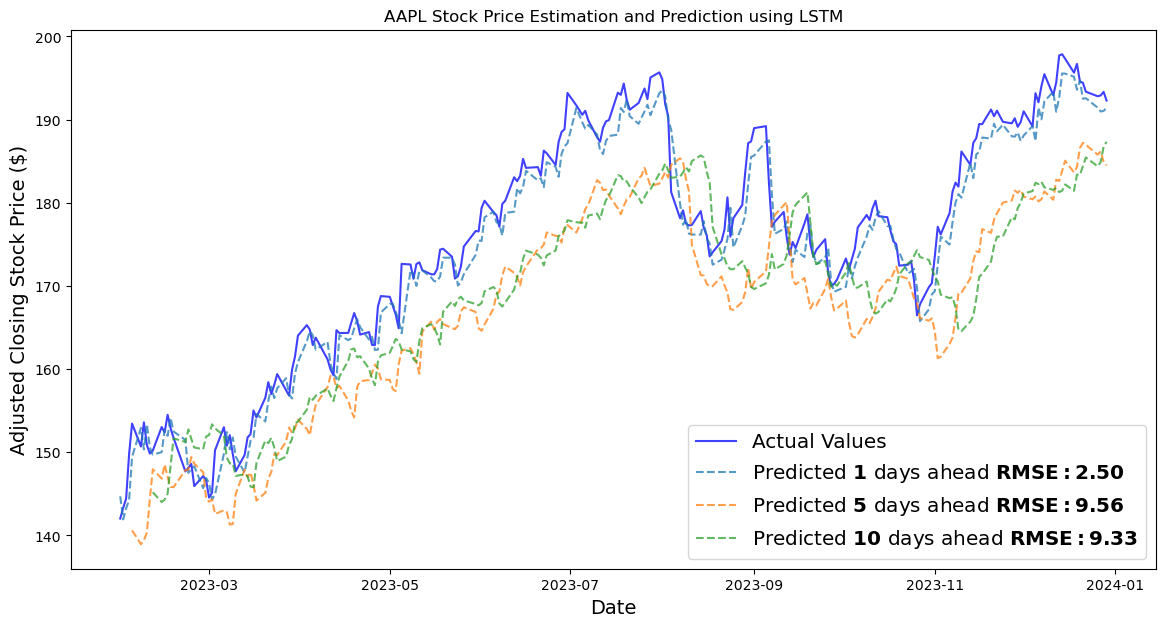

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.Date[look_back:], one_day_ahead_results[0], alpha=.75, c='blue', label='Actual Values')
plt.plot(test_data.Date[20:], one_day_ahead_results[1], alpha=.75, linestyle='--',
         label=f'Predicted $\\mathbf{{1}}$ days ahead $\\mathbf{{RMSE: {one_day_ahead_results[2]:.2f}}}$')
plt.plot(test_data.Date[24:], five_days_ahead_results[1], alpha=.75, linestyle='--',
         label=f'Predicted $\\mathbf{{5}}$ days ahead $\\mathbf{{RMSE: {five_days_ahead_results[2]:.2f}}}$')
plt.plot(test_data.Date[29:], ten_days_ahead_results[1], alpha=.75, linestyle='--',
         label=f'Predicted $\\mathbf{{10}}$ days ahead $\\mathbf{{RMSE: {ten_days_ahead_results[2]:.2f}}}$')
plt.title('AAPL Stock Price Estimation and Prediction using LSTM')
plt.xlabel('Date', fontsize=14), plt.ylabel('Adjusted Closing Stock Price ($)', fontsize=14)
plt.legend(fontsize='x-large'), plt.show();